In [4]:
# COLOR DISTORTION PSEUDOCODE
# Source: https://arxiv.org/pdf/2002.05709.pdf
import tensorflow as tf
def color_distortion(image, s=1.0):
  # image is a tensor with value range in [0, 1].
  # s is the strength of color distortion.
  def color_jitter(x):
  # one can also shuffle the order of following augmentations
  # each time they are applied.
    x = tf.image.random_brightness(x, max_delta=0.8*s)
    x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_hue(x, max_delta=0.2*s)
    x = tf.clip_by_value(x, 0, 1)
    return x

  def color_drop(x):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.tile(image, [1, 1, 3])
  # randomly apply transformation with probability p.
  image = color_jitter(image)
  image = color_drop(image)
  return image

In [11]:
def color_jitter(x, s=1.0):
  # one can also shuffle the order of following augmentations
  # each time they are applied.
    x = tf.image.random_brightness(x, max_delta=0.8*s)
    x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_hue(x, max_delta=0.2*s)
    x = tf.clip_by_value(x, 0, 1)
    return x

# https://www.tensorflow.org/api_docs/python/tf/image/random_brightness
# https://www.tensorflow.org/tutorials/images/data_augmentation

In [16]:
# COLOR DISTORTION TUTORIAL [STARTING FROM HERE BELOW]
#==================================================================
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

# Download Dataset
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [18]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


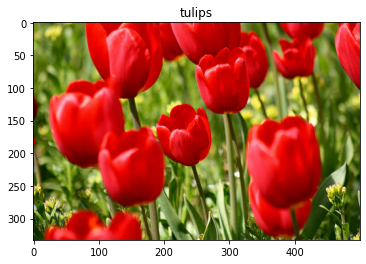

In [20]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [21]:
# use the following function to visualize and compare the original and augmented images side-by-side, to Visualize Results
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

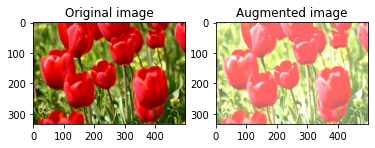

In [23]:
# Test Change Brightness
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

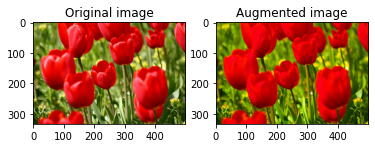

In [24]:
# Test Saturate Image
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

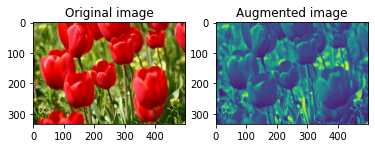

In [26]:
# Grayscale an image
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))

In [64]:
# Test Color Jitter V2 - Apply random combination of color distortion includes: change in brightness, contrast, saturation, and hue
def color_jitter_fix(image, s=1.0):
  # one can also shuffle the order of following augmentations
  # each time they are applied.
    image = tf.image.random_brightness(image, max_delta=0.8*s)
    image = tf.image.random_contrast(image, lower=1-0.8*s, upper=1+0.8*s)
    image = tf.image.random_saturation(image, lower=1-0.8*s, upper=1+0.8*s)
    image = tf.image.random_hue(image, max_delta=0.2*s)
    # image = tf.clip_by_value(image, 0, 1) - Commented this out since it causes most image output to be just black
    return image

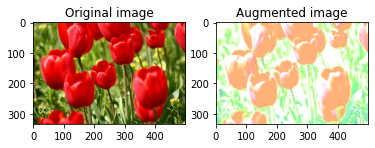

In [67]:
distorted_out = color_jitter_fix(image, 1.0)
visualize(image, distorted_out)

In [63]:
# Test Color Drop V2 - To change image to Grayscale
def color_drop_fix(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.tile(image, [1, 1, 3])
    return image

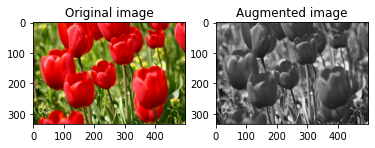

In [62]:
distorted_out2 = color_drop_fix(image)
visualize(image, distorted_out2)

In [85]:
# Apply augmentation to dataset
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [80]:
# Resize and rescale image to a uniform size
IMG_SIZE = 224
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [70]:
# using tf.data.experimental.Counter
# Create a `Counter` object and `Dataset.zip` it together with the training set.
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

Image Detected
Image Detected
Image Detected
Image Detected
Image Detected
Image Detected
Image Detected
Image Detected
Image Detected
Image Detected
Image Detected


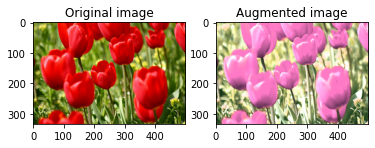

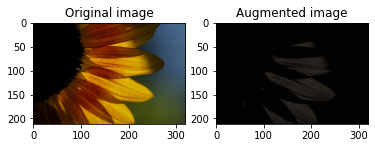

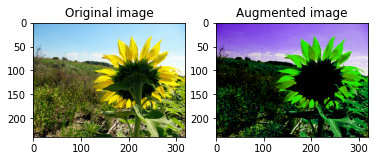

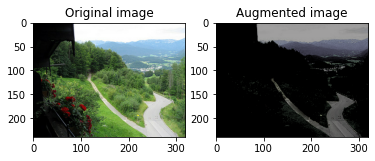

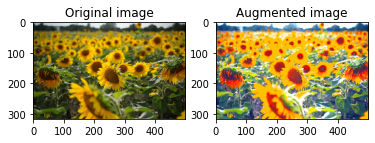

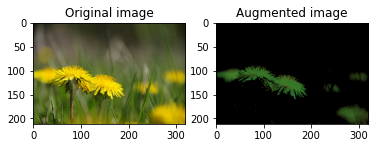

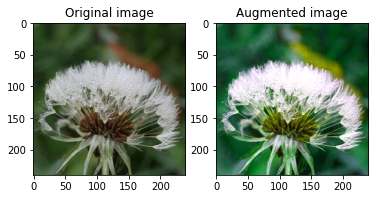

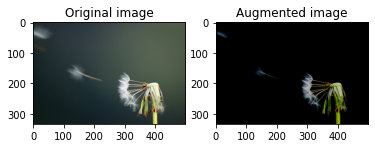

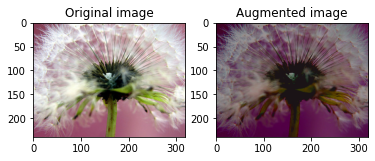

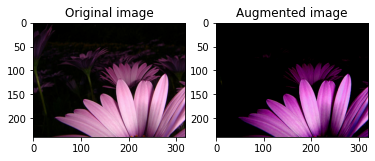

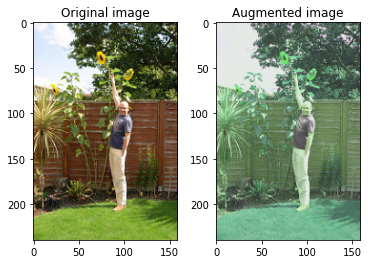

In [90]:
i = 0
for image, label in train_datasets:
  if i <= 10:
    print("Image Detected")
    image_distor = color_jitter_fix(image)
    visualize(image, image_distor)
  i += 1

In [78]:
print(train_ds)

<PrefetchDataset element_spec=((TensorSpec(shape=(None, None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), (TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)))>


In [81]:
# Validation Dataset
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [82]:
# Test Dataset
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)